### Assignment 2 Understanding transfer learning and fine tuning 

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import random_split
from torchvision import datasets
import os 
import numpy as np 
from typing import Literal
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pprint import pprint
import seaborn as sns
import pandas as pd
print(f"[INFO] Torch infos: {torch.__version__}")


[INFO] Torch infos: 2.6.0+cu124


# We need transform from resnet18 and its weights


In [2]:
transform = ResNet18_Weights.DEFAULT.transforms()

# pick a dataset  you can import from

```python
from torchvision import datasets
```

# Easy picks:

- Food101
- Flowers102
- DTD
- FGVAircraft

# Other picks:

```python

full_train = datasets.OxfordIIITPet(root="data", split="trainval", download=True, transform=transform)
test_ds    = datasets.OxfordIIITPet(root="data", split="test", download=True, transform=transform)

```


In [14]:
full_train = datasets.FGVCAircraft('../Dataset', split="trainval", transform=transform, download=True)
test_ds = datasets.FGVCAircraft('../Dataset', split="test", download=True, transform=transform)

className = full_train.classes

print(f"Number of Classes: {len(className)}")

Number of Classes: 100


# Split the data

In [4]:
train_ratio = 0.8
train_size = int(len(full_train) * train_ratio)

validation_size = len(full_train) - train_size

train_ds, validation_ds = random_split(full_train, [train_size, validation_size])

print("Train Size:", train_size)
print("Validation Size:", validation_size)
print("Train and Validation Ds", train_ds, validation_ds)

Train Size: 5333
Validation Size: 1334
Train and Validation Ds <torch.utils.data.dataset.Subset object at 0x0000026842FFA350> <torch.utils.data.dataset.Subset object at 0x0000026842FF91D0>


# load the train, validation and test split 

In [5]:

print(f"Training set size: {len(train_ds)} samples")
print(f"Validation set size: {len(validation_ds)} samples")
print(f"Test set size: {len(test_ds)} samples")

assert len(train_ds) + len(validation_ds) == len(full_train)

Training set size: 5333 samples
Validation set size: 1334 samples
Test set size: 3333 samples


# create dataloader handler from the dataset

In [70]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)

# now create the cnn, use the resnet18 as backbone, and ResNet18_Weights as initial weights.
- create the backbone
- create a classifier 
- based on your dataset add the correct number of output classes
- the classifier have to be trainable.

# Question 1?
- Why we freeze the backbone? Why not the classifier?

# add the train evaluation, and predict functions here

In [7]:
class Resnet18TransferLearning(nn.Module):
    def __init__(self, number_of_output_classes: int, weights=ResNet18_Weights.DEFAULT, freeze_backbone: bool = True, dense_units: list[int] = [256], dropout_probabilities: float = 0.3):
        super().__init__()

        self.weights = weights 

        backbone = resnet18(weights=weights)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.backbone_out = backbone.fc.in_features

        if freeze_backbone:
            for p in self.features.parameters():
                p.requires_grad = False
        
        mlp = []
        cur = self.backbone_out
        for h in dense_units:
            mlp += [
                nn.Linear(cur, h),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_probabilities),
            ]

            cur = h

        self.classifier = nn.Sequential(*mlp)

        self.final_classifier = nn.Linear(cur, number_of_output_classes)

        for p in self.classifier.parameters():
            p.requires_grad = True
        
        for p in self.final_classifier.parameters():
            p.requires_grad = True
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return self.final_classifier(x)

    def get_transform(self):
        return self.weights.transforms()


### Phase 1: Transfer learning

# freeze all layers except the classifier.
- train and evaluate the model for 50 epochs 
- remember to save val loss and train loss

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[DEVICE] Device loaded: {device}")

cnn_configuration = {
    "number_of_output_classes": 100,
    "freeze_backbone": True,
    "dense_units": [256],
    "dropout_probabilities": 0.3
}

model = Resnet18TransferLearning(**cnn_configuration).to(device)
pprint(model)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
loss_function = nn.CrossEntropyLoss()

[DEVICE] Device loaded: cuda
Resnet18TransferLearning(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momen

In [9]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    return running_loss/total, correct/total

In [10]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()  # Turn off Dropout / BatchNorm
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Track stats
        running_loss += loss.item() * images.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
    return running_loss / total, correct / total

In [ ]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

epochs = 50
best_validation_accuracy = 0.0

print(f"[INFO] Starting Phase 1 Training for {epochs} epochs on device: {device}...")

for epoch in range(1, epochs + 1):

    train_loss, train_acc = train_one_epoch(
        model=model, 
        loader=train_loader, 
        criterion=loss_function, 
        optimizer=optimizer, 
        device=device
    )
    
    val_loss, val_acc = evaluate(
        model=model, 
        loader=validation_loader, 
        criterion=loss_function, 
        device=device
    )
    
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)
    
    print(f"[EPOCH {epoch}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

    
    if val_acc > best_validation_accuracy:
        best_validation_accuracy = val_acc
        torch.save(model.state_dict(), "cnn_aircraft_transfer_learning.pt")
        

print("\nTRAINING COMPLETE!!!")
print(f"BEST VALIDATION ACCURACY: {best_validation_accuracy:.2%}")

[INFO] Starting Phase 1 Training for 50 epochs on device: cuda...
[EPOCH 1/50] Train Loss: 4.5415, Train Acc: 2.61% | Val Loss: 4.3728, Val Acc: 7.65%
  --> [SAVED] New best model saved with accuracy: 7.65%
[EPOCH 2/50] Train Loss: 4.1244, Train Acc: 8.91% | Val Loss: 3.9283, Val Acc: 11.77%
  --> [SAVED] New best model saved with accuracy: 11.77%
[EPOCH 3/50] Train Loss: 3.6964, Train Acc: 13.91% | Val Loss: 3.5444, Val Acc: 18.29%
  --> [SAVED] New best model saved with accuracy: 18.29%
[EPOCH 4/50] Train Loss: 3.3477, Train Acc: 19.82% | Val Loss: 3.3097, Val Acc: 20.16%
  --> [SAVED] New best model saved with accuracy: 20.16%
[EPOCH 5/50] Train Loss: 3.1091, Train Acc: 24.15% | Val Loss: 3.1300, Val Acc: 24.44%
  --> [SAVED] New best model saved with accuracy: 24.44%
[EPOCH 6/50] Train Loss: 2.9145, Train Acc: 27.10% | Val Loss: 2.9771, Val Acc: 26.61%
  --> [SAVED] New best model saved with accuracy: 26.61%
[EPOCH 7/50] Train Loss: 2.7720, Train Acc: 30.11% | Val Loss: 2.9010, Val

# Plot accuracy and loss

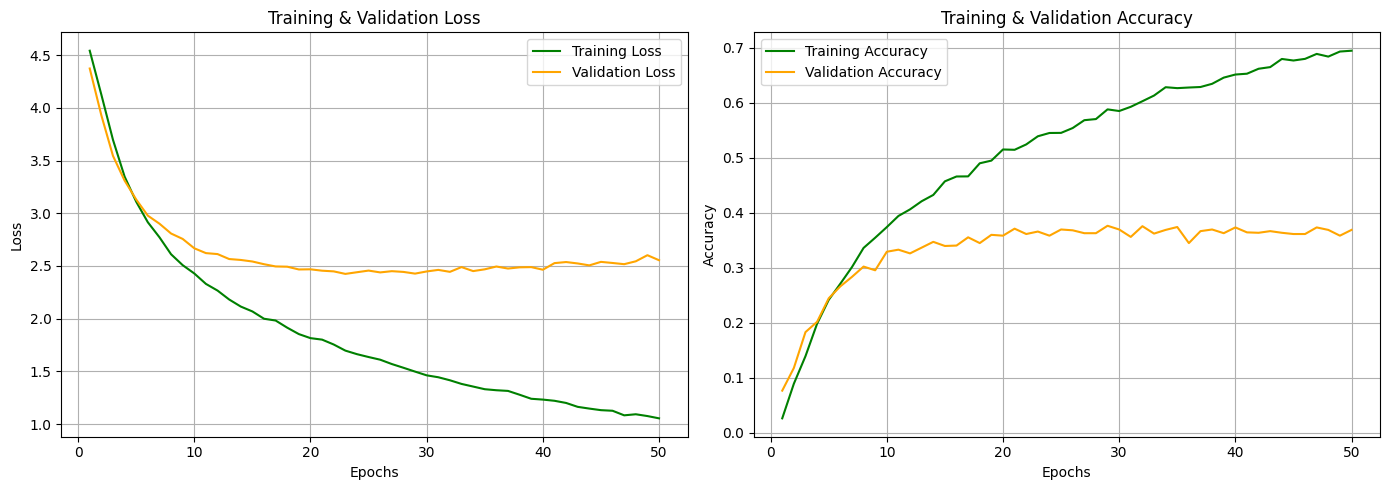

In [52]:
epochs_range = range(1, len(training_loss) + 1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_loss, label='Training Loss', color='green')
plt.plot(epochs_range, validation_loss, label='Validation Loss', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy', color='green')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# plot predictions 

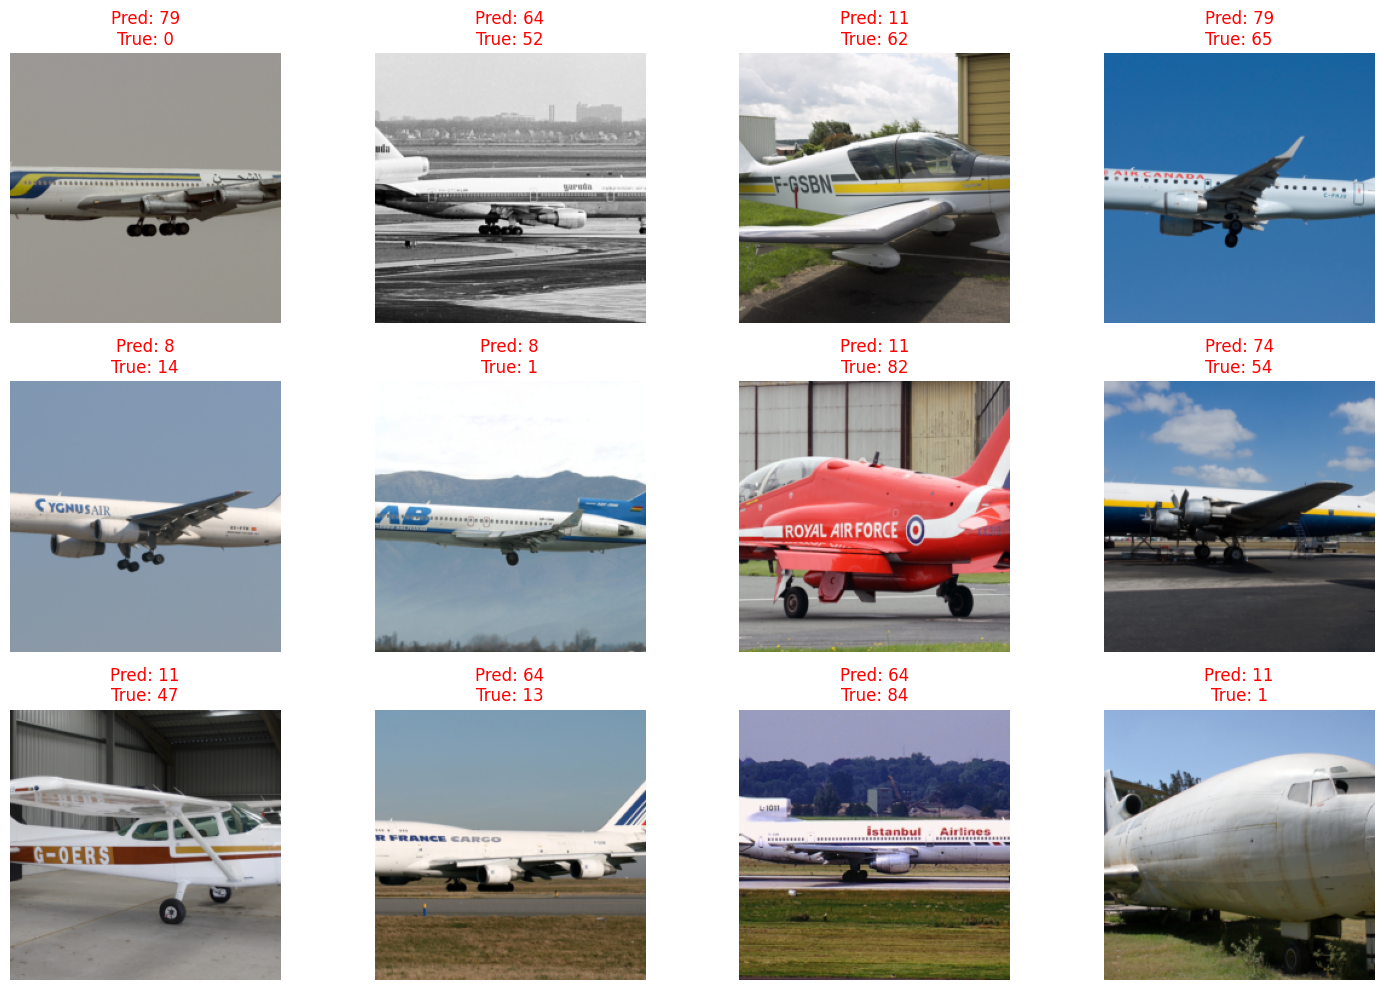

In [ ]:
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

model.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)


fig = plt.figure(figsize=(15, 10))
num_images_to_show = 12

for idx in range(num_images_to_show):
    ax = fig.add_subplot(3, 4, idx + 1, xticks=[], yticks=[])

    imshow(images[idx])

    pred_label = preds[idx].item()
    truth_label = labels[idx].item()
    
    color = 'green' if pred_label == truth_label else 'red'

    ax.set_title(f"Pred: {pred_label}\nTrue: {truth_label}", color=color)

plt.tight_layout()
plt.show()

# calculate TEST accuracy score 

In [80]:
test_loss, test_acc = evaluate(
    model=model, 
    loader=test_loader, 
    criterion=loss_function, 
    device=device
)

print(f"FINAL TEST ACCURACY: {test_acc * 100:.2%} | FINAL TEST LOSS: {test_loss:.4f}")



FINAL TEST ACCURACY: 66.01% | FINAL TEST LOSS: 4.6580


# Calculate confusion matrices precision and recall 

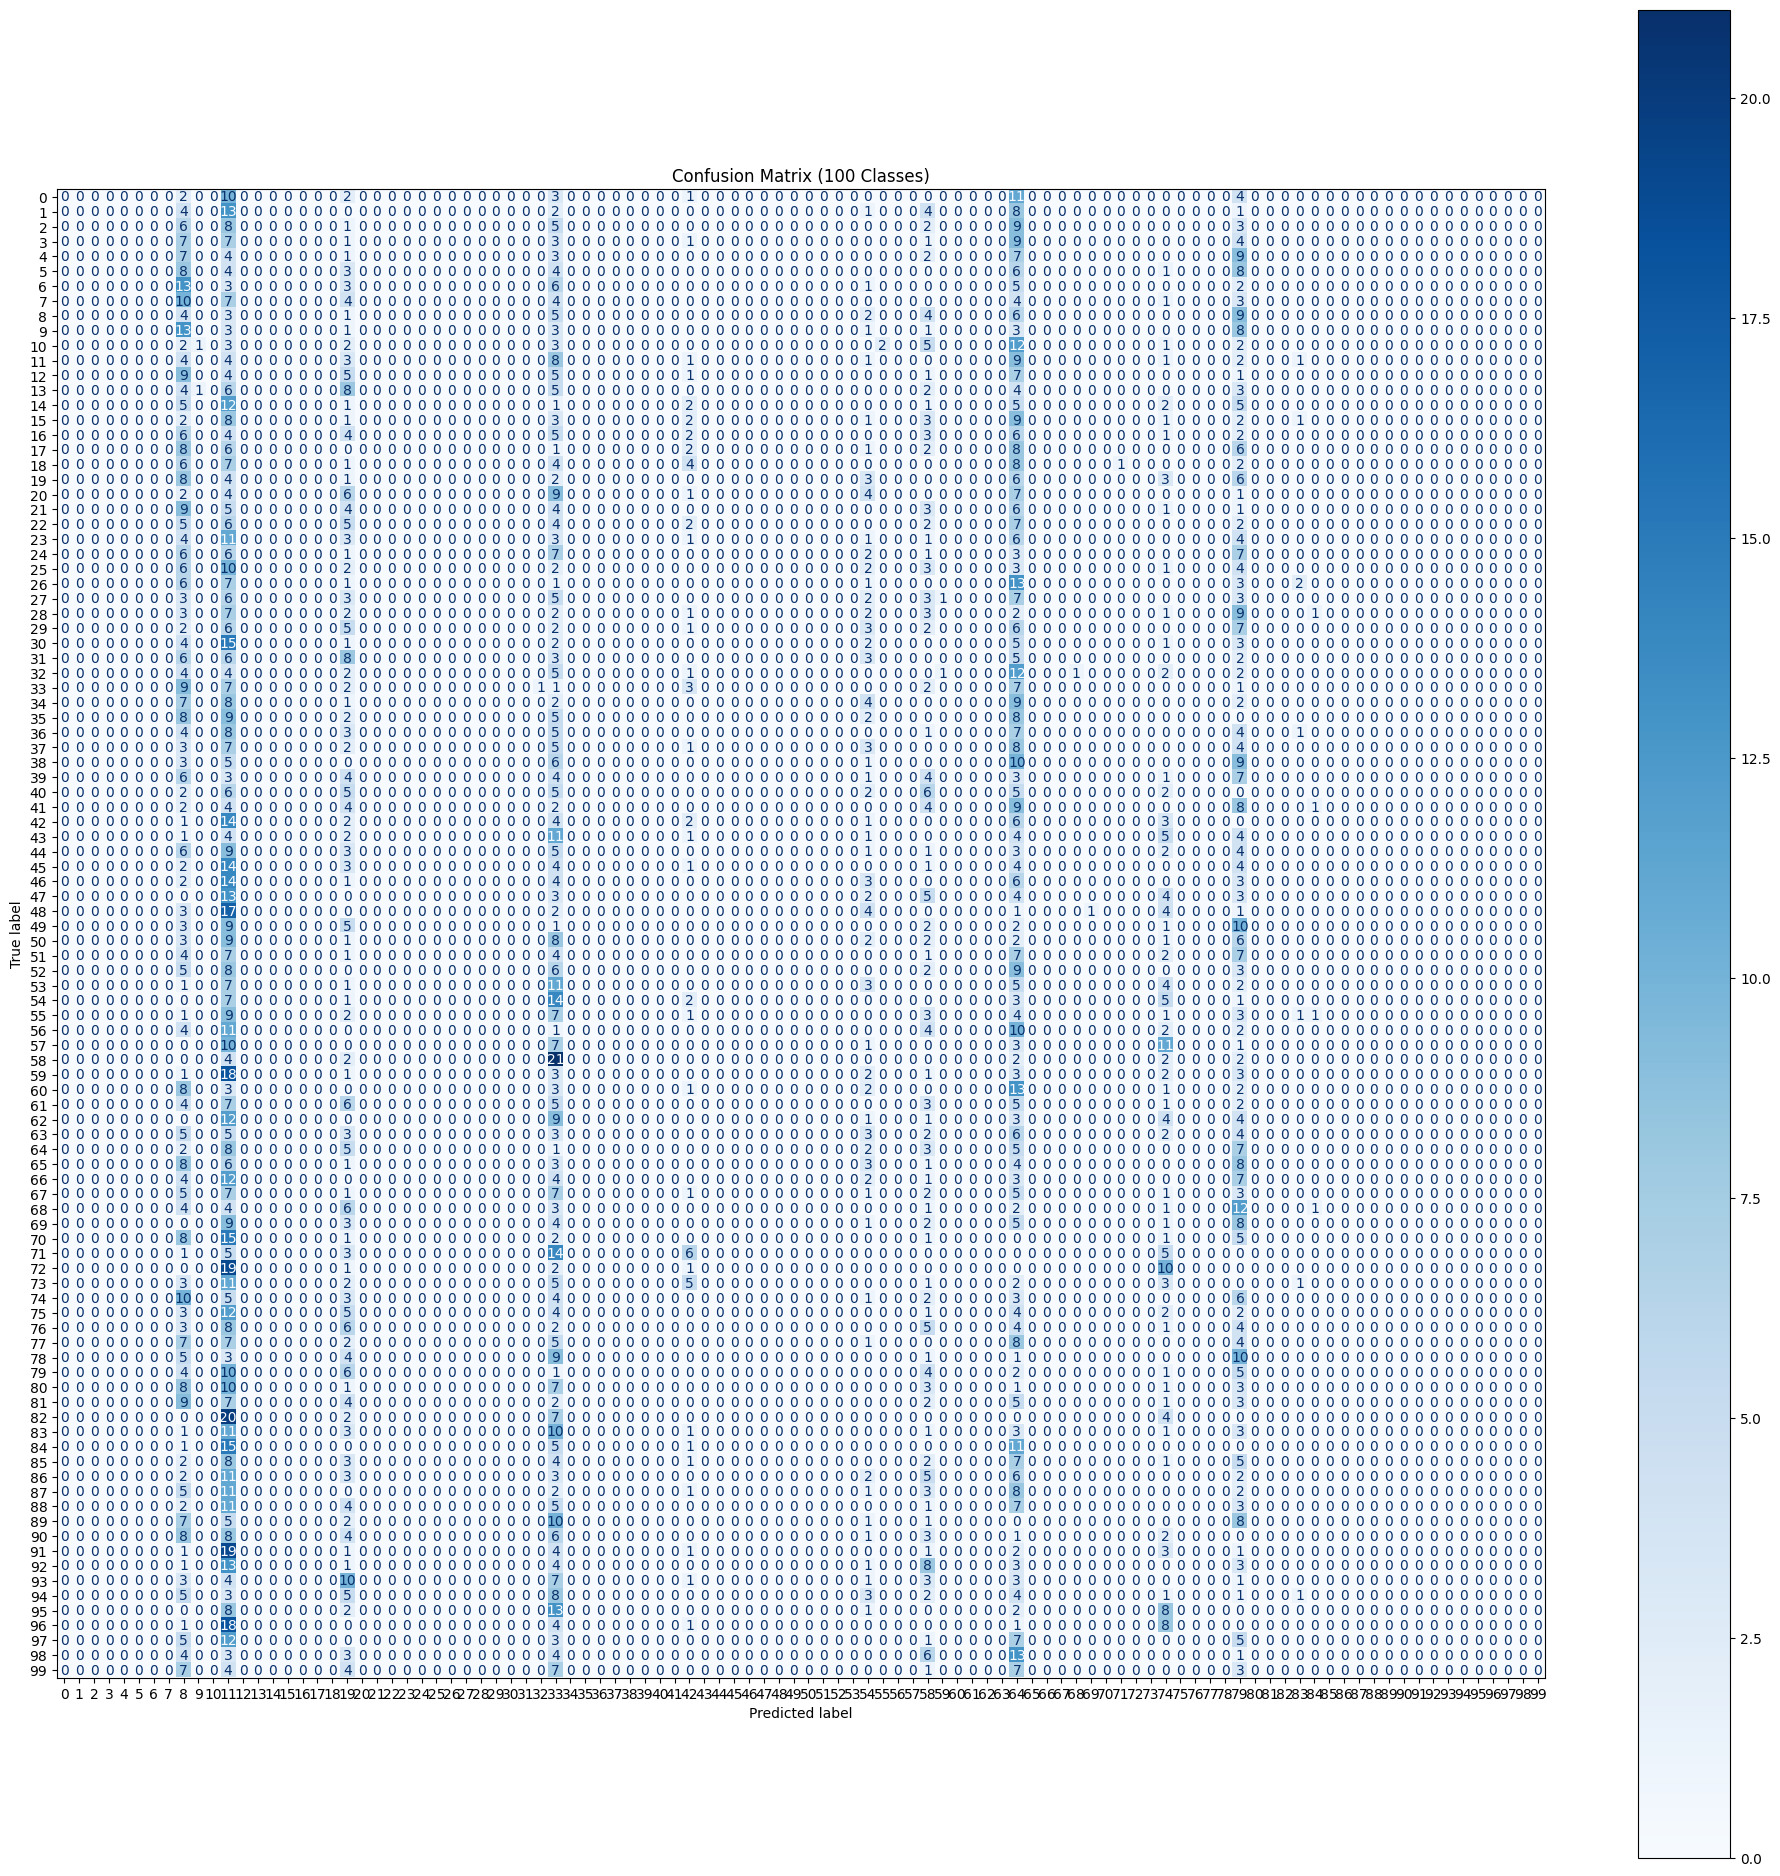

In [88]:
# 1. Gather all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Move to CPU and convert to list
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Generate and Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(24, 24))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title('Confusion Matrix (100 Classes)')
plt.show()

### Phase 2: Freeze layer 4 - Fine tuning

# from the freezed cnn unfreeze the  ``` layer4 ```. 

# Train for 50 epochs 

# Plot curves

# visualize prediction

# Calculate test accuracy score 

# calculate confusion matrix precision and recall

# Question 2 What did you learn? What is the difference between transfer learning and fine tuning? 